# Black Friday

The dataset here is a sample of the transactions made in a retail store. Here the problem is a regression problem where we are trying to predict the dependent variable (the amount of purchase) with the help of the information contained in the other variables.
At the end we are trying to solve classification problem - "Predict the category of goods bought".

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix

%matplotlib inline
RANDOM_STATE = 42

# EDA

In [2]:
black_friday_df = pd.read_csv('BlackFriday.csv', low_memory=False)

In [3]:
black_friday_df.head().T

,0,1,2,3,4
User_ID,1000001,1000001,1000001,1000001,1000002
Product_ID,P00069042,P00248942,P00087842,P00085442,P00285442
Gender,F,F,F,F,M
Age,0-17,0-17,0-17,0-17,55+
Occupation,10,10,10,10,16
City_Category,A,A,A,A,C
Stay_In_Current_City_Years,2,2,2,2,4+
Marital_Status,0,0,0,0,0
Product_Category_1,3,1,12,12,8
Product_Category_2,NaN,6,NaN,14,NaN


In [4]:
black_friday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


In [5]:
black_friday_df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.375770e+05,537577.00000,537577.000000,537577.000000,370591.000000,164278.000000,537577.000000
mean,1.002992e+06,8.08271,0.408797,5.295546,9.842144,12.669840,9333.859853
std,1.714393e+03,6.52412,0.491612,3.750701,5.087259,4.124341,4981.022133
min,1.000001e+06,0.00000,0.000000,1.000000,2.000000,3.000000,185.000000
25%,1.001495e+06,2.00000,0.000000,1.000000,5.000000,9.000000,5866.000000
50%,1.003031e+06,7.00000,0.000000,5.000000,9.000000,14.000000,8062.000000
75%,1.004417e+06,14.00000,1.000000,8.000000,15.000000,16.000000,12073.000000
max,1.006040e+06,20.00000,1.000000,18.000000,18.000000,18.000000,23961.000000


In [6]:
null_values = black_friday_df.isnull().sum().reset_index(name='Number of null values')
null_values['% of null values'] = null_values['Number of null values'] / len(black_friday_df) * 100
null_values

,index,Number of null values,% of null values
0,User_ID,0,0.000000
1,Product_ID,0,0.000000
2,Gender,0,0.000000
3,Age,0,0.000000
4,Occupation,0,0.000000
5,City_Category,0,0.000000
6,Stay_In_Current_City_Years,0,0.000000
7,Marital_Status,0,0.000000
8,Product_Category_1,0,0.000000
9,Product_Category_2,166986,31.062713


There is 31% of missing values in Product_Category_2 and 69% in Product_Category_3. We will not uses these columns in the model, because, as we can see from the data bellow, every product has a unique Product_Category_1 assigend. If a product is assigned to Product_Category_2 or/and Product_Category_3, it is also unique.

In [7]:
prod_id_df = (black_friday_df[['Product_ID', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3']]
              .groupby('Product_ID')
              .nunique())
prod_id_df.head()


,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3
Product_ID,,,,
P00000142,1,1,1,1
P00000242,1,1,1,1
P00000342,1,1,1,0
P00000442,1,1,1,0
P00000542,1,1,0,0


In [8]:
prod_id_df.describe()

,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3
count,3623.0,3623.0,3623.000000,3623.000000
mean,1.0,1.0,0.496826,0.145184
std,0.0,0.0,0.500059,0.352334
min,1.0,1.0,0.000000,0.000000
25%,1.0,1.0,0.000000,0.000000
50%,1.0,1.0,0.000000,0.000000
75%,1.0,1.0,1.000000,0.000000
max,1.0,1.0,1.000000,1.000000


### Unique values

In [9]:
black_friday_unique = black_friday_df.nunique().reset_index(name='Number of unique')
black_friday_unique

,index,Number of unique
0,User_ID,5891
1,Product_ID,3623
2,Gender,2
3,Age,7
4,Occupation,21
5,City_Category,3
6,Stay_In_Current_City_Years,5
7,Marital_Status,2
8,Product_Category_1,18
9,Product_Category_2,17


In [10]:
list(black_friday_df['Gender'].unique())

['F', 'M']

In [11]:
sorted(list(black_friday_df['Age'].unique()))

['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']

### Purchase amount distribution

Text(0.5, 1.0, 'Purchase amount distribution')

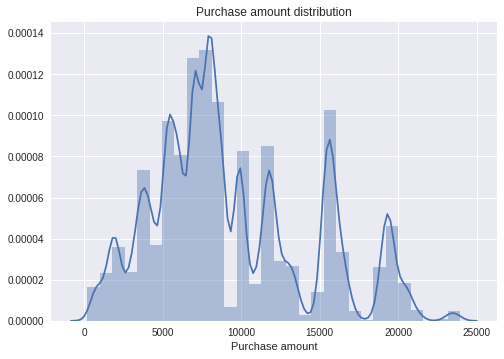

In [12]:
plt.style.use('seaborn')
sns.distplot(black_friday_df['Purchase'], bins=30)
plt.xlabel('Purchase amount')
plt.title('Purchase amount distribution')

### Correlation matrix

In [13]:
black_friday_df.corr()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
User_ID,1.000000,-0.023024,0.018732,0.003687,0.001471,0.004045,0.005389
Occupation,-0.023024,1.000000,0.024691,-0.008114,-0.000031,0.013452,0.021104
Marital_Status,0.018732,0.024691,1.000000,0.020546,0.015116,0.019452,0.000129
Product_Category_1,0.003687,-0.008114,0.020546,1.000000,0.540423,0.229490,-0.314125
Product_Category_2,0.001471,-0.000031,0.015116,0.540423,1.000000,0.543544,-0.209973
Product_Category_3,0.004045,0.013452,0.019452,0.229490,0.543544,1.000000,-0.022257
Purchase,0.005389,0.021104,0.000129,-0.314125,-0.209973,-0.022257,1.000000


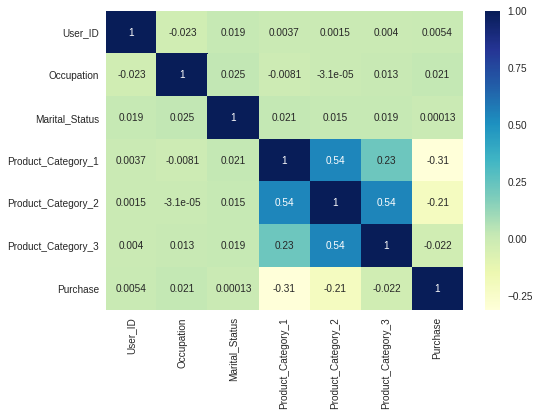

In [14]:
sns.heatmap(black_friday_df.corr(), annot=True, cmap='YlGnBu')

# Gender

In [15]:
grouped_by_gender = (black_friday_df[['Gender', 'Purchase']]
                     .groupby('Gender', as_index=False)
                     .agg(['count', 'sum', 'mean', 'median', 'min', 'max']))
grouped_by_gender

Purchase                                            
          count         sum         mean median  min    max
Gender                                                     
F        132197  1164624021  8809.761349   7929  185  23959
M        405380  3853044357  9504.771713   8112  185  23961

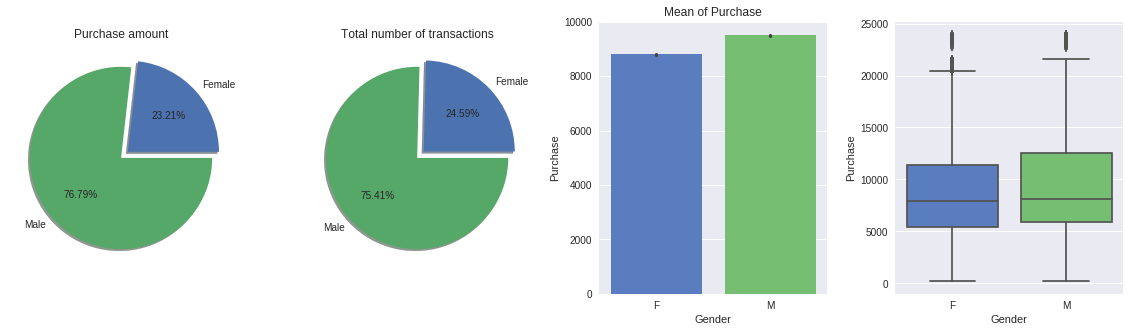

In [16]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
plt.style.use('seaborn-muted')
parameters = {
    'labels': grouped_by_gender.index.map({'M': 'Male', 'F': 'Female'}),
    'autopct': '%.2f%%',
    'explode': (0.1, 0),
    'shadow': True
}
ax[0].pie(grouped_by_gender['Purchase']['sum'], **parameters)
ax[1].pie(grouped_by_gender['Purchase']['count'], **parameters)
sns.barplot(x=black_friday_df['Gender'], y=black_friday_df['Purchase'], data=black_friday_df, ax=ax[2])
sns.boxplot(x='Gender',y='Purchase',data=black_friday_df, ax=ax[3])
plt.subplots_adjust(wspace=0.3)
ax[0].set_title('Purchase amount')
ax[1].set_title('Total number of transactions')
ax[2].set_title('Mean of Purchase')
plt.show()

# Age

Text(0.5, 1.0, 'Total Number of Purchase transactions based on Age')

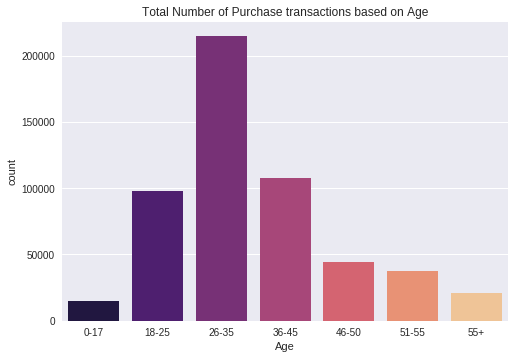

In [17]:
sns.countplot(black_friday_df['Age'], palette = 'magma', order=sorted(black_friday_df.Age.unique()))
plt.title('Total Number of Purchase transactions based on Age')

Text(0.5, 1.0, 'Total Number of Purchase transactions based on Age and Gender')

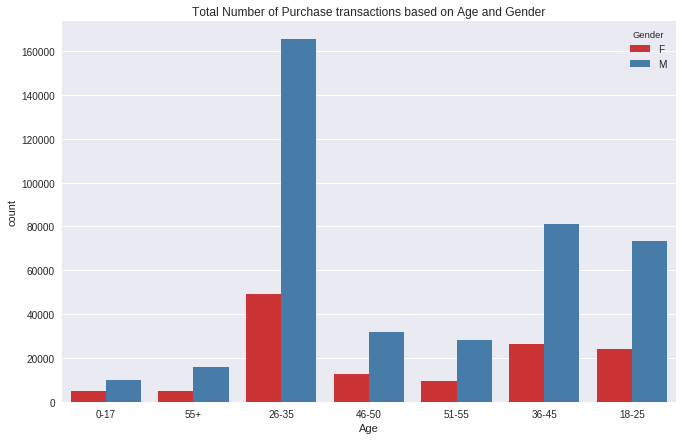

In [18]:
plt.figure(figsize=(11,7))
sns.countplot(x='Age', hue='Gender', data=black_friday_df, palette='Set1')
plt.title('Total Number of Purchase transactions based on Age and Gender')

In [19]:
grouped_by_age = (black_friday_df[['Age', 'Purchase']]
                  .groupby('Age')
                  .describe()
                  .sort_index())
grouped_by_age

Purchase                                                             \
          count         mean          std    min     25%     50%       75%   
Age                                                                          
0-17    14707.0  9020.126878  5060.498917  187.0  5365.0  8009.0  11904.50   
18-25   97634.0  9235.197575  4995.723417  185.0  5439.0  8041.0  12044.00   
26-35  214690.0  9314.588970  4974.081415  185.0  5833.0  8043.0  12063.00   
36-45  107499.0  9401.478758  4978.252054  185.0  5910.0  8076.0  12131.00   
46-50   44526.0  9284.872277  4921.253566  186.0  5921.0  8050.0  12021.75   
51-55   37618.0  9620.616620  5035.326515  187.0  6056.0  8172.0  12578.50   
55+     20903.0  9453.898579  4939.124514  187.0  6068.0  8127.0  11976.00   

                
           max  
Age             
0-17   23955.0  
18-25  23958.0  
26-35  23961.0  
36-45  23960.0  
46-50  23960.0  
51-55  23960.0  
55+    23960.0

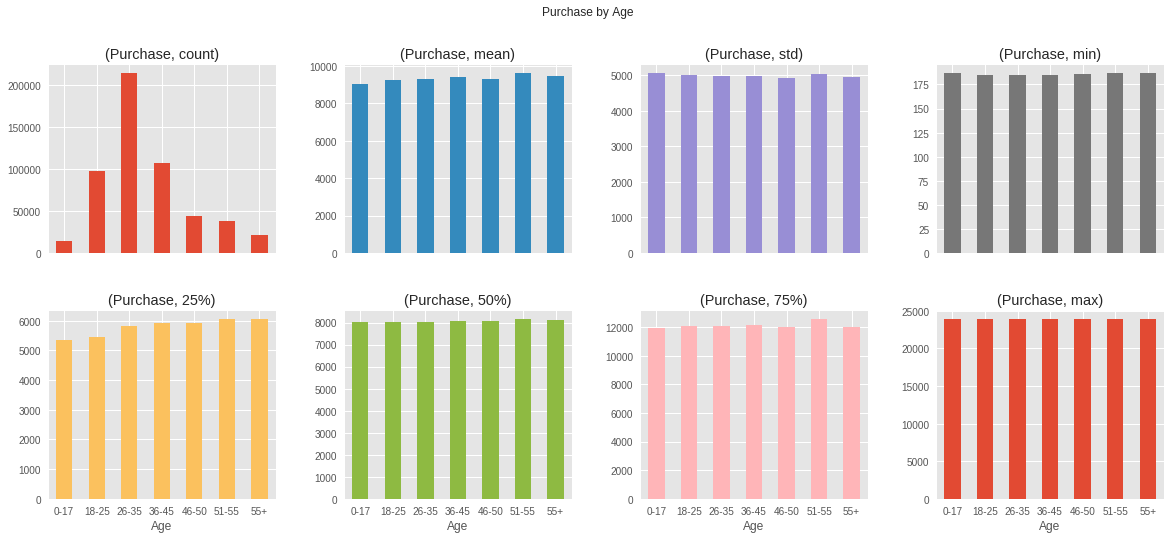

In [20]:
plt.style.use('ggplot')
grouped_by_age.plot(kind='bar', rot=0, subplots=True, layout=(2,4), figsize=(20,8), title='Purchase by Age', legend=False)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

# Occupation

Text(0.5, 1.0, 'Total Number of transactions based on Occupation')

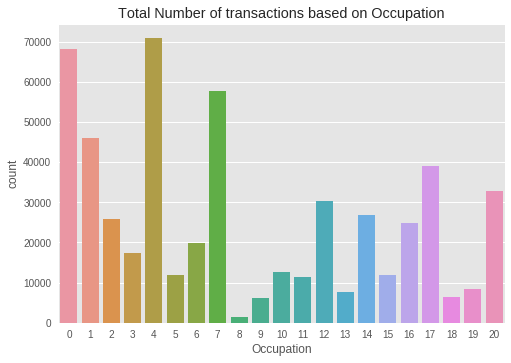

In [21]:
sns.countplot(black_friday_df.Occupation)
plt.title('Total Number of transactions based on Occupation')

Text(0.5, 1.0, 'Total Number of transactions based on Occupation and Gender')

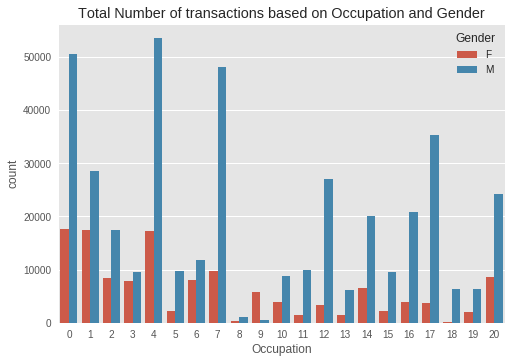

In [22]:
sns.countplot(black_friday_df['Occupation'].sort_values(), hue=black_friday_df['Gender'].sort_values())
plt.title('Total Number of transactions based on Occupation and Gender')

In [23]:
black_friday_df.groupby(['Gender', 'Occupation'])['Purchase'].agg(['count', 'sum', 'mean', 'median', 'min', 'max'])

count        sum          mean  median  min    max
Gender Occupation                                                    
F      0           17658  157280334   8907.029901  7962.0  190  23940
       1           17431  149248540   8562.247720  7870.0  185  23933
       2            8402   71231716   8477.947632  7864.0  375  23955
       3            7767   70901242   9128.523497  8019.0  188  23860
       4           17340  149423449   8617.269262  7868.0  186  23950
       5            2160   19265353   8919.144907  7912.5  559  23799
       6            7971   73074822   9167.585247  8039.0  191  23951
       7            9707   89152642   9184.366128  8006.0  191  23919
       8             357    3351960   9389.243697  8656.0  575  23869
       9            5707   49485777   8671.066585  7891.0  209  23943
       10           3912   32494711   8306.418967  7758.0  197  23847
       11           1454   13386486   9206.661623  8007.0  556  23659
       12           3387   31344117   9254.241807  8087.0  377  23769
       13           1445   12582934   8707.912803  8016.0  204  23959
       14           6621   57199979   8639.175200  7830.0  202  23730
       15           2302   21852037   9492.631190  8095.0  370  23948
       16           3996   36030879   9016.736486  8017.5  350  23941
       17           3742   36034969   9629.868787  8131.0  371  23948
       18            216    2184342  10112.694444  8745.0  744  23398
       19           1974   16743544   8482.038501  7788.0  381  23830
       20           8648   72354188   8366.580481  7759.5  188  23915
M      0           50462  468534477   9284.897091  8036.0  188  23961
       1           28540  265304289   9295.875578  8052.0  194  23960
       2           17443  162043677   9289.897208  8025.0  197  23954
       3            9599   89527208   9326.722367  8022.0  213  23914
       4           53522  508106944   9493.422219  8126.0  185  23961
       5            9825   93260002   9492.112163  8133.0  209  23924
       6           11851  111990875   9449.909290  8095.0  188  23923
       7           48099  460130102   9566.313271  8103.0  187  23948
       8            1167   11242639   9633.795201  8332.0  193  23425
       9             446    4133532   9268.008969  8023.5  564  23233
       10           8711   81779243   9388.043049  8162.0  187  23955
       11           9884   92050873   9313.119486  8075.0  185  23946
       12          27036  269327988   9961.828229  8629.0  187  23960
       13           6103   58552810   9594.102900  8141.0  193  23955
       14          20091  198394766   9874.807924  8617.0  197  23941
       15           9510   94687989   9956.676025  8621.0  200  23949
       16          20794  198411451   9541.764499  8090.0  199  23947
       17          35348  351205386   9935.650843  8687.0  186  23961
       18           6309   58065364   9203.576478  7949.0  206  23894
       19           6378   56371945   8838.498746  7875.5  185  23939
       20          24262  219922797   9064.495796  7965.0  186  23960

# Marital_Status

In [24]:
marital_status = (black_friday_df[['Marital_Status', 'Purchase']]
                  .groupby('Marital_Status')
                  .describe()
                  .sort_index())
marital_status

Purchase                                                   \
                   count         mean          std    min     25%     50%   
Marital_Status                                                              
0               317817.0  9333.325467  4985.253932  185.0  5850.0  8059.0   
1               219760.0  9334.632681  4974.906972  186.0  5886.0  8066.0   

                                  
                    75%      max  
Marital_Status                    
0               12080.0  23961.0  
1               12065.0  23961.0

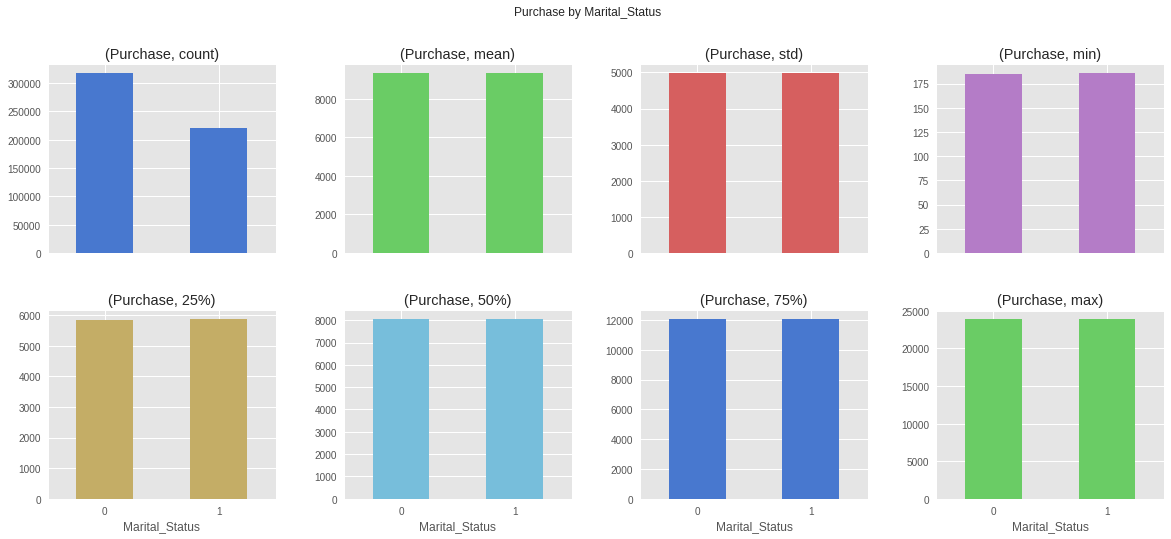

In [25]:
plt.style.use('seaborn-muted')
(marital_status.plot(kind='bar',
                     rot=0,
                     subplots=True,
                     layout=(2,4),
                     figsize=(20,8),
                     title='Purchase by Marital_Status',
                     legend=False))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

# Product_Category_1

Text(0.5, 1.0, 'Total Number of transactions based on Product_Category_1')

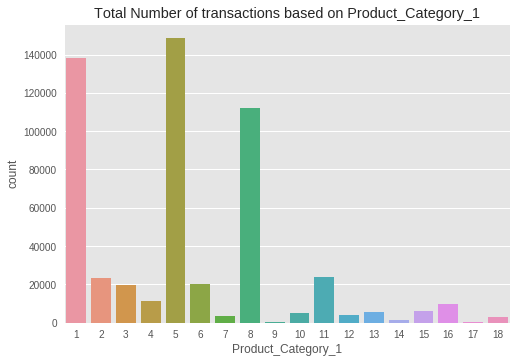

In [26]:
sns.countplot(black_friday_df.Product_Category_1)
plt.title('Total Number of transactions based on Product_Category_1')

Text(0.5, 1.0, 'Total Number of transactions based on Product_Category_1')

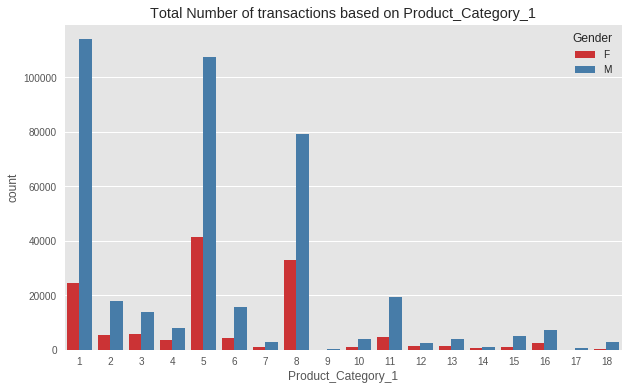

In [27]:
plt.figure(figsize=(10,6))
(sns.countplot(black_friday_df['Product_Category_1'].sort_values(),
               hue=black_friday_df['Gender'].sort_values(),
               palette='Set1'))
plt.title('Total Number of transactions based on Product_Category_1')

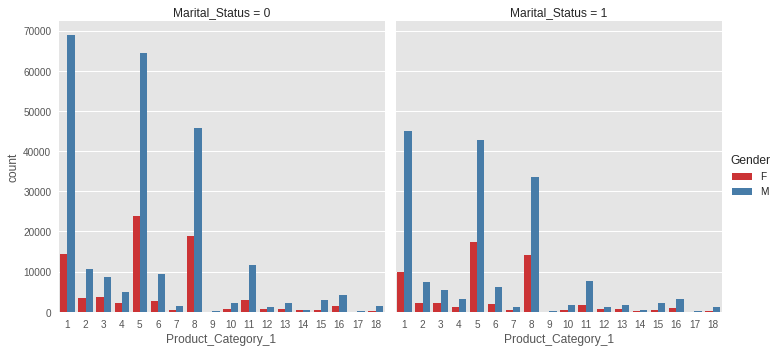

In [28]:
(sns.catplot(x='Product_Category_1',
             hue='Gender',
             col='Marital_Status',
             data=black_friday_df,
             kind='count',
             palette='Set1'))

# Product_ID

In [29]:
grouped_by_product_id = black_friday_df.groupby(['Product_ID'])['Purchase'].agg(['count', 'sum'])

#### Top/bottom Products based on number and amount of transactions

In [30]:
grouped_by_product_id['count'].nlargest(5).reset_index(name='Number of transactions')

,Product_ID,Number of transactions
0,P00265242,1858
1,P00110742,1591
2,P00025442,1586
3,P00112142,1539
4,P00057642,1430


In [31]:
grouped_by_product_id['count'].nsmallest(5).reset_index(name='Number of transactions')

,Product_ID,Number of transactions
0,P00008942,1
1,P00012342,1
2,P00012942,1
3,P00013442,1
4,P00013542,1


In [32]:
grouped_by_product_id['sum'].nlargest(5).reset_index(name='Amount of Purchase')

,Product_ID,Amount of Purchase
0,P00025442,27532426
1,P00110742,26382569
2,P00255842,24652442
3,P00184942,24060871
4,P00059442,23948299


In [33]:
grouped_by_product_id['sum'].nsmallest(5).reset_index(name='Amount of Purchase')

,Product_ID,Amount of Purchase
0,P00091742,405
1,P00309042,726
2,P00353042,1545
3,P00325342,1656
4,P00012942,1717


# City_Category

In [34]:
black_friday_df.groupby('City_Category')['Purchase'].describe()

,count,mean,std,min,25%,50%,75%,max
City_Category,,,,,,,,
A,144638.0,8958.011014,4866.896600,185.0,5419.0,7941.0,11801.75,23961.0
B,226493.0,9198.657848,4927.062965,185.0,5477.0,8015.0,12000.00,23960.0
C,166446.0,9844.441855,5109.472100,186.0,6094.0,8618.0,13268.00,23961.0


In [35]:
grouped_by_city_category = black_friday_df.groupby('City_Category')['Purchase'].agg(['count', 'sum', 'mean'])
grouped_by_city_category

,count,sum,mean
City_Category,,,
A,144638,1295668797,8958.011014
B,226493,2083431612,9198.657848
C,166446,1638567969,9844.441855


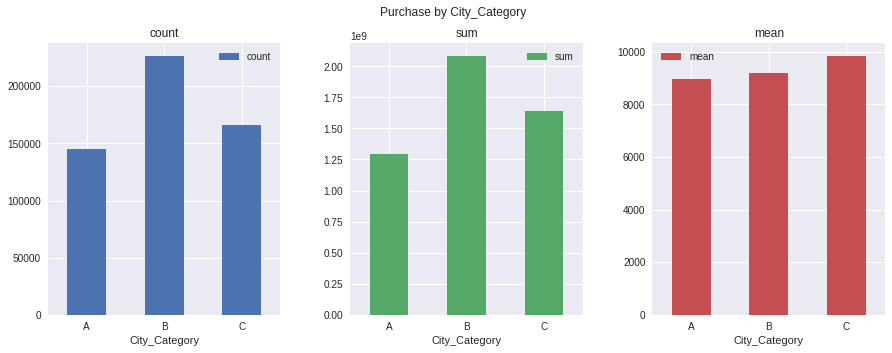

In [36]:
plt.style.use('seaborn')
(grouped_by_city_category.plot(kind='bar',
                               rot=0,
                               subplots=True,
                               layout=(1,3),
                               figsize=(15,5),
                               title='Purchase by City_Category'))
plt.subplots_adjust(wspace=0.3)
plt.show()

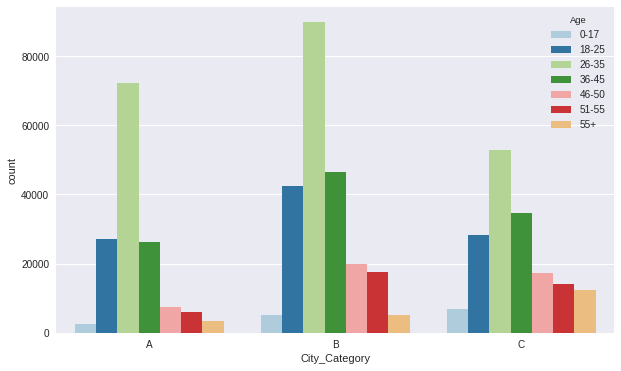

In [37]:
plt.figure(figsize=(10,6))
(sns.countplot(black_friday_df['City_Category'].sort_values(),
              hue=black_friday_df['Age'].sort_values(),
              palette='Paired'))

# Stay_In_Current_City_Years

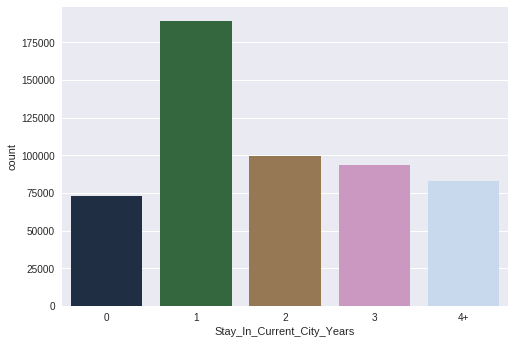

In [38]:
(sns.countplot(black_friday_df.Stay_In_Current_City_Years,
               order=sorted(black_friday_df.Stay_In_Current_City_Years.unique()),
               palette='cubehelix'))

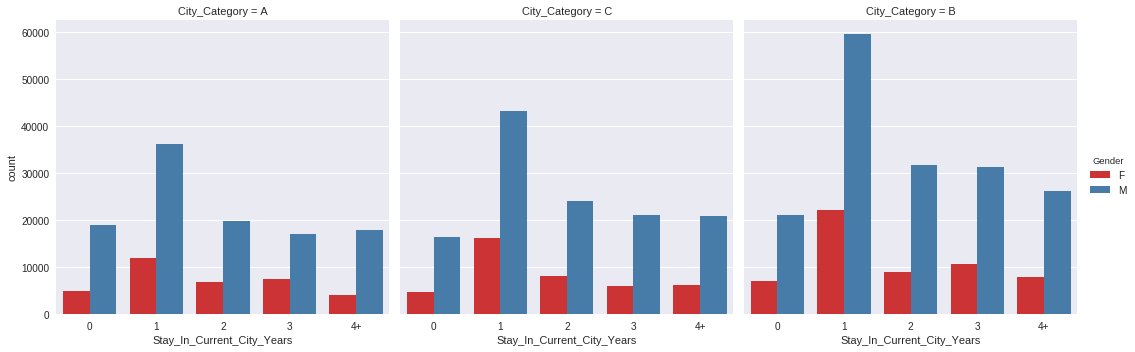

In [39]:
(sns.catplot(x='Stay_In_Current_City_Years',
             hue='Gender',
             col='City_Category',
             data=black_friday_df, kind='count',
             order=sorted(black_friday_df.Stay_In_Current_City_Years.unique()), palette='Set1'))

# Data Pre-Processing

In [40]:
black_friday_df.head().T

,0,1,2,3,4
User_ID,1000001,1000001,1000001,1000001,1000002
Product_ID,P00069042,P00248942,P00087842,P00085442,P00285442
Gender,F,F,F,F,M
Age,0-17,0-17,0-17,0-17,55+
Occupation,10,10,10,10,16
City_Category,A,A,A,A,C
Stay_In_Current_City_Years,2,2,2,2,4+
Marital_Status,0,0,0,0,0
Product_Category_1,3,1,12,12,8
Product_Category_2,NaN,6,NaN,14,NaN


In [41]:
black_friday_df.shape

(537577, 12)

In [42]:
black_friday_data = black_friday_df.drop(['Product_Category_2', 'Product_Category_3'], axis=1)

In [43]:
black_friday_data.shape

(537577, 10)

In [44]:
black_friday_data.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Purchase                      0
dtype: int64

In [45]:
# Converting Gender & Age to numeric values
black_friday_data['Gender'] = black_friday_data['Gender'].map({'F': 0, 'M': 1}).astype(int)
black_friday_data['Age'] = (black_friday_data['Age']
                            .map({'0-17': 17,
                                  '18-25': 25,
                                  '26-35': 35,
                                  '36-45': 45,
                                  '46-50': 50,
                                  '51-55': 55,
                                  '55+': 75})
                            .astype(int))

In [46]:
black_friday_data.Gender.unique(), black_friday_data.Age.unique()

(array([0, 1]), array([17, 75, 35, 50, 55, 45, 25]))

In [47]:
# Label encoding Product ID, User ID and Stay_In_Current_City_Years
black_friday_data['User_ID'] = LabelEncoder().fit_transform(black_friday_data['User_ID'])
black_friday_data['Product_ID'] = LabelEncoder().fit_transform(black_friday_data['Product_ID'])
black_friday_data['Stay_In_Current_City_Years'] = LabelEncoder().fit_transform(black_friday_data['Stay_In_Current_City_Years'])

In [48]:
# Dummies for City_Category
city_cat_dummies = pd.get_dummies(black_friday_data.City_Category, drop_first=True, prefix="city_").astype(int)
black_friday_encoded = pd.concat([black_friday_data, city_cat_dummies], axis=1)
black_friday_encoded.drop(['City_Category'], axis=1, inplace=True)
black_friday_encoded_cl = black_friday_encoded.copy()
black_friday_encoded.head().T

,0,1,2,3,4
User_ID,0,0,0,0,1
Product_ID,670,2374,850,826,2732
Gender,0,0,0,0,1
Age,17,17,17,17,75
Occupation,10,10,10,10,16
Stay_In_Current_City_Years,2,2,2,2,4
Marital_Status,0,0,0,0,0
Product_Category_1,3,1,12,12,8
Purchase,8370,15200,1422,1057,7969
city__B,0,0,0,0,0


In [49]:
# Dependenant variable
y = black_friday_encoded.pop('Purchase')

In [50]:
black_friday_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 10 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null int64
Gender                        537577 non-null int64
Age                           537577 non-null int64
Occupation                    537577 non-null int64
Stay_In_Current_City_Years    537577 non-null int64
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
city__B                       537577 non-null int64
city__C                       537577 non-null int64
dtypes: int64(10)
memory usage: 41.0 MB


In [51]:
black_friday_encoded.shape, y.shape

((537577, 10), (537577,))

### Splitting data

In [52]:
X_train, X_test, y_train, y_test = (train_test_split(black_friday_encoded,
                                                     y,
                                                     test_size=0.30,
                                                     random_state=RANDOM_STATE))

### Functions to run models

In [53]:
# Test data metrics summary 
test_metrics = pd.DataFrame(columns = ['RMSE', 'R2_Score'])

# Function to run a model
def run_model(model,
              model_name,
              train_data=X_train,
              test_data=X_test,
              train_labels=y_train,
              test_target=y_test):
    model.fit(train_data, train_labels)
    pred_train = model.predict(train_data)
    pred_test = model.predict(test_data)
    
    print('Train RMSE:', np.sqrt(mean_squared_error(train_labels, pred_train)))
    print('Test RMSE:', np.sqrt(mean_squared_error(test_target, pred_test)))
    print('Train R2 score:', r2_score(y_train, pred_train))
    print('Test R2 score:', r2_score(y_test, pred_test))
    
    # Writing metrics to summary data frame
    test_metrics.loc[model_name, 'RMSE'] = np.sqrt(mean_squared_error(y_test, pred_test))
    test_metrics.loc[model_name, 'R2_Score'] = r2_score(y_test, pred_test)


In [54]:
# Function to run a model with GridSearchCV
def grid_searched(model,
                  grid_params,
                  model_name,
                  train_data=X_train,
                  test_data=X_test,
                  train_labels=y_train,
                  test_target=y_test):
    grid_searched_model = (GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3))

    grid_searched_model.fit(train_data, train_labels)
    
    print('Best params: ', grid_searched_model.best_params_)
    
    best_model = grid_searched_model.best_estimator_
    best_model.fit(train_data, train_labels)
    best_model_pred_train = best_model.predict(X_train)
    best_model_pred_test = best_model.predict(X_test)
    
    print('Train RMSE:', np.sqrt(mean_squared_error(train_labels, best_model_pred_train)))
    print('Test RMSE:', np.sqrt(mean_squared_error(test_target, best_model_pred_test)))
    print('Train R2 score:', r2_score(y_train, best_model_pred_train))
    print('Test R2 score:', r2_score(y_test, best_model_pred_test))
    
    # Writing metrics to summary data frame
    if model_name not in test_metrics.index:
        test_metrics.loc[model_name, 'RMSE'] = np.sqrt(mean_squared_error(y_test, best_model_pred_test))
        test_metrics.loc[model_name, 'R2_Score'] = r2_score(y_test, best_model_pred_test)
        
    return best_model


In [55]:
# Feature importance function
def feature_importance(model, index=X_train.columns):
    feat_importance = (pd.DataFrame(model.feature_importances_,
                                    index=index,
                                    columns=['importance']).sort_values('importance',ascending=False))
    return feat_importance

# LinearRegression

In [57]:
linear = LinearRegression()

In [58]:
run_model(linear, 'Linear_Regression_')

Train RMSE: 4691.692994212797
Test RMSE: 4697.75134549211
Train R2 score: 0.11289227971722793
Test R2 score: 0.11027791853551094


# DecisionTreeRegressor

In [59]:
dtree = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100, random_state=RANDOM_STATE)

In [60]:
run_model(dtree, 'DecisionTreeRegressor')

Train RMSE: 2722.776244846612
Test RMSE: 2763.658082375509
Train R2 score: 0.7012271754268837
Test R2 score: 0.692076424583506


In [61]:
feature_importance(dtree)

,importance
Product_Category_1,0.896081
Product_ID,0.093991
city__C,0.002937
User_ID,0.002223
Age,0.001557
Occupation,0.001416
Gender,0.000714
Stay_In_Current_City_Years,0.000511
city__B,0.000400
Marital_Status,0.000170


# RandomForestRegressor

In [62]:
forest = RandomForestRegressor(n_estimators=20, max_features='log2', n_jobs=-1, random_state=RANDOM_STATE)

In [63]:
run_model(forest, 'RandomForestRegressor')

Train RMSE: 1166.134163775311
Test RMSE: 2959.912064336752
Train R2 score: 0.9451957517538323
Test R2 score: 0.6467908580712243


In [64]:
feature_importance(forest)

,importance
Product_Category_1,0.559952
Product_ID,0.243602
User_ID,0.088694
Occupation,0.040424
Stay_In_Current_City_Years,0.024241
Age,0.022662
Marital_Status,0.007328
Gender,0.005045
city__C,0.004447
city__B,0.003606


# GradientBoostingRegressor

In [65]:
gbrt = GradientBoostingRegressor(max_depth = 3, learning_rate = 0.1)

In [66]:
run_model(gbrt, 'GradientBoostingRegressor')

Train RMSE: 2933.0221152156246
Test RMSE: 2940.931564826836
Train R2 score: 0.653304773318955
Test R2 score: 0.6513062563348656


In [67]:
feature_importance(gbrt)

,importance
Product_Category_1,0.954448
Product_ID,0.039298
city__C,0.003740
Occupation,0.000844
Age,0.000766
User_ID,0.000612
city__B,0.000220
Gender,0.000054
Stay_In_Current_City_Years,0.000018
Marital_Status,0.000000


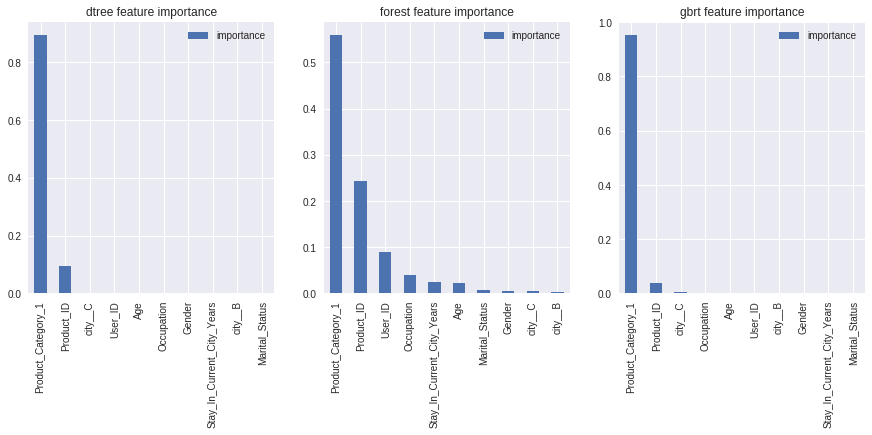

In [68]:
f,axes = plt.subplots(1, 3, figsize=(15,5))
feature_importance(dtree).plot(kind='bar', ax=axes[0], title='dtree feature importance')
feature_importance(forest).plot(kind='bar', ax=axes[1], title='forest feature importance')
feature_importance(gbrt).plot(kind='bar', ax=axes[2], title='gbrt feature importance')

# GridSearchCV - DecissionTree

In [69]:
dtree_param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [50, 100, 150]
}

In [70]:
dtree_for_grid_search = DecisionTreeRegressor(random_state=RANDOM_STATE)

In [71]:
best_tree = grid_searched(dtree_for_grid_search, dtree_param_grid, 'Tree_GridSearchCV')

Best params:  {'max_depth': 20, 'min_samples_leaf': 50}
Train RMSE: 2633.3261137685363
Test RMSE: 2748.957022515698
Train R2 score: 0.720535608736928
Test R2 score: 0.6953436615538073


In [72]:
feature_importance(best_tree)

,importance
Product_Category_1,0.872362
Product_ID,0.106384
User_ID,0.007320
Occupation,0.003429
city__C,0.003173
Age,0.003070
Stay_In_Current_City_Years,0.001575
Gender,0.001167
city__B,0.000771
Marital_Status,0.000748


# GridSearchCV Random Forest

In [73]:
forest_param_grid = {
    'max_depth': [10, 30],
    'max_features': ['log2'],
    'n_estimators': [10, 30],
}

In [74]:
forest_for_grid_search = RandomForestRegressor(random_state=RANDOM_STATE)

In [75]:
best_forest = grid_searched(forest_for_grid_search, forest_param_grid, 'Forest_GridSearchCV')

Best params:  {'max_depth': 30, 'max_features': 'log2', 'n_estimators': 30}
Train RMSE: 1238.5847706281502
Test RMSE: 2909.978681865289
Train R2 score: 0.9381743546212308
Test R2 score: 0.6586075339120854


In [77]:
feature_importance(best_forest)

,importance
Product_Category_1,0.578776
Product_ID,0.228103
User_ID,0.087084
Occupation,0.039352
Stay_In_Current_City_Years,0.024432
Age,0.021326
Marital_Status,0.007452
Gender,0.004978
city__C,0.004361
city__B,0.004136


# GridSearchCV GradientBoostingRegressor

In [78]:
gbrt_param_grid = {
    'max_depth': [1, 3, 5],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100]
}

In [79]:
gbrt_for_grid_search = GradientBoostingRegressor()

In [80]:
best_gbrt = grid_searched(gbrt_for_grid_search, gbrt_param_grid, 'GrdBoostRegr_GridSearchCV')

Best params:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Train RMSE: 2734.5448817276174
Test RMSE: 2754.536911024154
Train R2 score: 0.6986388262726351
Test R2 score: 0.6941056111348349


In [81]:
feature_importance(best_gbrt)

,importance
Product_Category_1,0.903101
Product_ID,0.075835
User_ID,0.010072
city__C,0.003704
Occupation,0.002232
Age,0.002169
Stay_In_Current_City_Years,0.001285
Gender,0.000703
city__B,0.000566
Marital_Status,0.000334


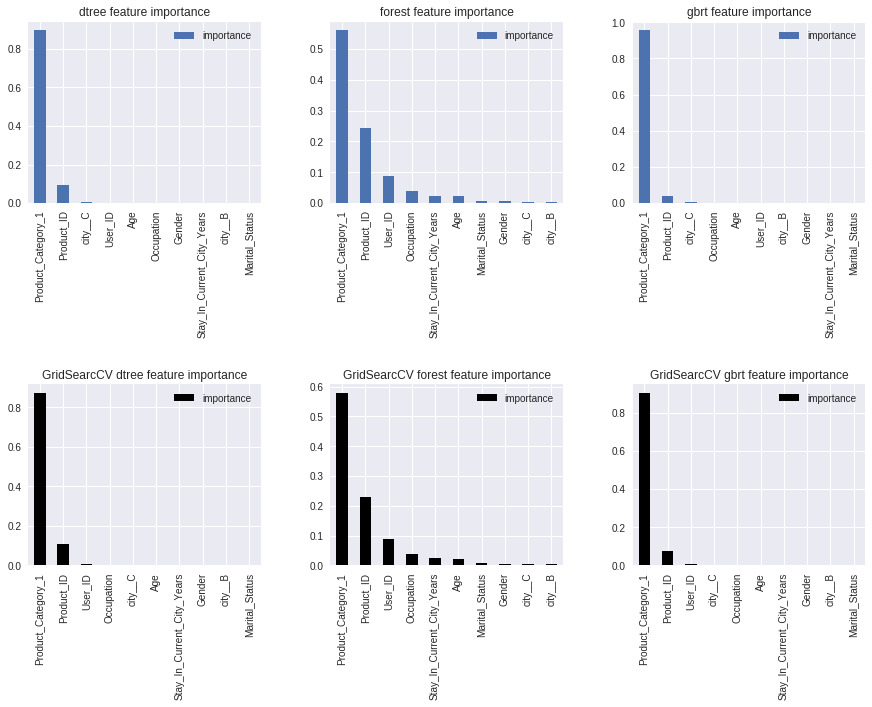

In [82]:
f,axes = plt.subplots(2, 3, figsize=(15,10))
plt.subplots_adjust(wspace=0.3, hspace=1)
feature_importance(dtree).plot(kind='bar', ax=axes[0,0], title='dtree feature importance')
feature_importance(forest).plot(kind='bar', ax=axes[0,1], title='forest feature importance')
feature_importance(gbrt).plot(kind='bar', ax=axes[0,2], title='gbrt feature importance')
feature_importance(best_tree).plot(kind='bar', ax=axes[1,0], title='GridSearcCV dtree feature importance', color='k')
feature_importance(best_forest).plot(kind='bar', ax=axes[1,1], title='GridSearcCV forest feature importance', color='k')
feature_importance(best_gbrt).plot(kind='bar', ax=axes[1,2], title='GridSearcCV gbrt feature importance', color='k')

# Regression - Test data metrics summary

In [83]:
test_metrics

,RMSE,R2_Score
Linear_Regression_,4697.75,0.110278
DecisionTreeRegressor,2763.66,0.692076
RandomForestRegressor,2959.91,0.646791
GradientBoostingRegressor,2940.93,0.651306
Tree_GridSearchCV,2748.96,0.695344
Forest_GridSearchCV,2909.98,0.658608
GrdBoostRegr_GridSearchCV,2754.54,0.694106


# Classification - Predict the Product_Category_1

In [56]:
black_friday_encoded_cl.head().T

,0,1,2,3,4
User_ID,0,0,0,0,1
Product_ID,670,2374,850,826,2732
Gender,0,0,0,0,1
Age,17,17,17,17,75
Occupation,10,10,10,10,16
Stay_In_Current_City_Years,2,2,2,2,4
Marital_Status,0,0,0,0,0
Product_Category_1,3,1,12,12,8
Purchase,8370,15200,1422,1057,7969
city__B,0,0,0,0,0


In [57]:
y_cl = black_friday_encoded_cl.pop('Product_Category_1')

In [58]:
black_friday_encoded_cl.shape, y_cl.shape

((537577, 10), (537577,))

In [59]:
# Splitting train and test sets
X_train_cl, X_test_cl, y_train_cl, y_test_cl = (train_test_split(black_friday_encoded_cl, y_cl,
                                                                 test_size=0.30,
                                                                 random_state=RANDOM_STATE))

In [60]:
forest_cl = (RandomForestClassifier(max_depth = 10,
                                    max_features='sqrt',
                                    n_estimators=15,
                                    n_jobs=-1,
                                    random_state=RANDOM_STATE))
forest_cl.fit(X_train_cl, y_train_cl)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [61]:
pred_train = forest_cl.predict(X_train_cl)
pred_test = forest_cl.predict(X_test_cl)

# Accuracy
train_acc = accuracy_score(y_train_cl, pred_train)
test_acc = accuracy_score(y_test_cl, pred_test)

print("Accuracy on training set: {:.3f}".format(train_acc))
print("Accuracy on test set: {:.3f}".format(test_acc))

Accuracy on training set: 0.732
Accuracy on test set: 0.729


In [62]:
print(classification_report(y_test_cl, pred_test))

              precision    recall  f1-score   support

           1       0.76      0.84      0.80     41573
           2       0.73      0.18      0.29      7108
           3       0.96      0.37      0.54      5963
           4       0.90      0.13      0.23      3453
           5       0.68      0.98      0.80     44498
           6       0.86      0.32      0.47      6015
           7       0.77      0.06      0.12      1060
           8       0.74      0.87      0.80     33682
           9       0.00      0.00      0.00       136
          10       0.99      0.43      0.59      1552
          11       0.99      0.21      0.34      7119
          12       1.00      0.10      0.18      1122
          13       0.89      0.02      0.04      1622
          14       1.00      0.00      0.00       442
          15       0.82      0.23      0.36      1835
          16       0.77      0.25      0.38      2994
          17       0.00      0.00      0.00       166
          18       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
labels = forest_cl.classes_
pd.DataFrame(confusion_matrix(y_test_cl, pred_test), columns=labels, index=labels)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1,35024,0,22,0,3131,0,0,3395,0,0,1,0,0,0,0,0,0,0
2,2454,1302,17,8,807,0,0,2516,0,0,0,0,0,0,0,4,0,0
3,1030,152,2232,8,1002,0,0,1539,0,0,0,0,0,0,0,0,0,0
4,0,0,0,456,2991,0,0,2,0,0,0,0,4,0,0,0,0,0
5,0,0,0,8,43655,0,0,835,0,0,0,0,0,0,0,0,0,0
6,3385,19,3,0,343,1943,0,198,0,0,0,0,0,0,0,124,0,0
7,636,20,1,0,63,132,68,25,0,0,0,0,0,0,55,60,0,0
8,0,0,2,6,4266,0,0,29408,0,0,0,0,0,0,0,0,0,0
9,96,0,1,0,8,0,0,21,0,7,0,0,0,0,3,0,0,0
10,791,19,2,0,20,0,0,59,0,660,0,0,0,0,0,1,0,0


In [64]:
feature_importance(forest_cl, index=X_train_cl.columns)

,importance
Purchase,0.897451
Product_ID,0.081309
Gender,0.005171
User_ID,0.004829
Age,0.004721
Occupation,0.002847
Stay_In_Current_City_Years,0.001428
city__C,0.001201
Marital_Status,0.000528
city__B,0.000516


In [65]:
forest_cl_grid_params = {
    'max_depth': [10, 30],
    'max_features': ['sqrt'],
    'n_estimators': [10, 30]
}

In [66]:
forest_cl_for_grid_search = RandomForestClassifier(random_state=RANDOM_STATE)

In [67]:
forest_cl_grid_searched = (GridSearchCV(estimator=forest_cl_for_grid_search,
                                        param_grid=forest_cl_grid_params,
                                        cv=3))

In [68]:
forest_cl_grid_searched.fit(X_train_cl, y_train_cl)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [10, 30], 'max_features': ['sqrt'], 'n_estimators': [10, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [69]:
print('Best params: ', forest_cl_grid_searched.best_params_)

Best params:  {'max_depth': 30, 'max_features': 'sqrt', 'n_estimators': 30}


In [70]:
best_forest_cl = forest_cl_grid_searched.best_estimator_

In [71]:
best_forest_cl.fit(X_train_cl, y_train_cl)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [72]:
best_forest_cl_pred_train = forest_cl_grid_searched.predict(X_train_cl)
best_forest_cl_pred_test = forest_cl_grid_searched.predict(X_test_cl)

In [73]:
# Accuracy
best_forest_cl_train_acc = accuracy_score(y_train_cl, best_forest_cl_pred_train)
best_forest_cl_test_acc = accuracy_score(y_test_cl, best_forest_cl_pred_test)

print("Accuracy on training set: {:.3f}".format(best_forest_cl_train_acc))
print("Accuracy on test set: {:.3f}".format(best_forest_cl_test_acc))

Accuracy on training set: 0.999
Accuracy on test set: 0.893


In [74]:
print(classification_report(y_test_cl, best_forest_cl_pred_test))

              precision    recall  f1-score   support

           1       0.93      0.93      0.93     41573
           2       0.82      0.71      0.76      7108
           3       0.90      0.78      0.83      5963
           4       0.83      0.80      0.81      3453
           5       0.94      0.99      0.96     44498
           6       0.77      0.76      0.77      6015
           7       0.67      0.30      0.41      1060
           8       0.86      0.94      0.90     33682
           9       0.97      0.49      0.65       136
          10       0.93      0.75      0.83      1552
          11       0.86      0.77      0.81      7119
          12       0.89      0.83      0.86      1122
          13       0.91      0.93      0.92      1622
          14       0.81      0.27      0.41       442
          15       0.80      0.52      0.63      1835
          16       0.73      0.54      0.62      2994
          17       0.88      0.21      0.34       166
          18       0.77    

In [75]:
best_f_cl_labels = best_forest_cl.classes_
(pd.DataFrame(confusion_matrix(y_test_cl, best_forest_cl_pred_test),
              columns=best_forest_cl.classes_,
              index=labels))

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
1,38555,3,105,0,93,38,3,2501,0,3,223,0,0,8,10,16,1,14
2,138,5022,95,25,481,301,7,914,0,1,38,1,0,0,14,66,2,3
3,326,124,4640,75,286,8,0,427,0,0,46,0,0,2,5,11,0,13
4,0,6,6,2762,422,0,0,74,0,0,46,33,83,0,0,0,0,21
5,4,19,7,108,44138,1,2,102,0,0,74,23,1,0,1,2,0,16
6,557,210,46,0,145,4592,46,127,0,2,32,0,0,0,25,233,0,0
7,44,68,11,0,30,309,316,9,0,2,8,0,0,0,90,173,0,0
8,818,163,51,167,559,13,1,31653,1,0,203,9,0,2,3,7,1,31
9,16,9,6,0,6,0,0,9,66,19,3,0,0,0,2,0,0,0
10,275,29,24,0,9,1,2,32,0,1160,2,0,0,16,1,1,0,0


In [76]:
feature_importance(best_forest_cl, index=X_train_cl.columns)

,importance
Purchase,0.686688
Product_ID,0.175145
User_ID,0.056852
Occupation,0.028036
Stay_In_Current_City_Years,0.019421
Age,0.014357
Marital_Status,0.006418
city__B,0.005668
city__C,0.004213
Gender,0.003202


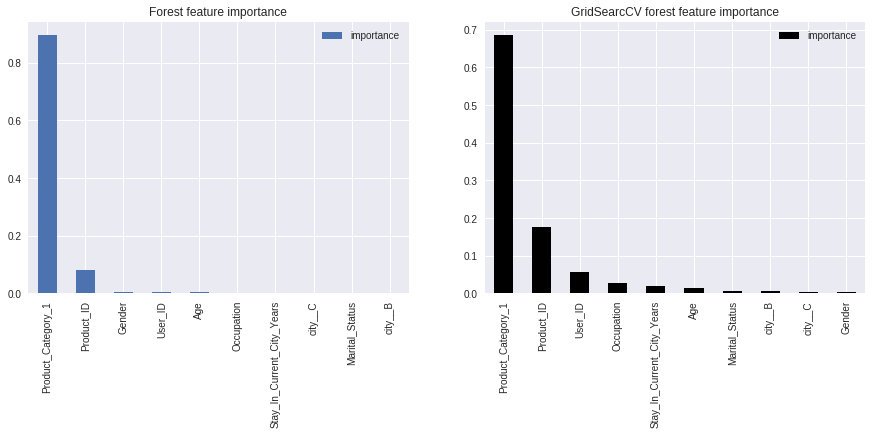

In [77]:
f,axes = plt.subplots(1, 2, figsize=(15, 5))
plt.style.use('seaborn')
feature_importance(forest_cl).plot(kind='bar', ax=axes[0], title='Forest feature importance')
(feature_importance(best_forest_cl).plot(kind='bar',
                                         ax=axes[1],
                                         title='GridSearcCV forest feature importance',
                                         color='k'))